Aim
---

To investigate up to what lmax and nside we need to model for temperature and lmax errors to be significantly less than the 21-cm signal.

## TO RE-RUN WITHOUT RE-GENERATING SKIP TO "RUN FROM HERE"

In [1]:
from functools import partial
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
from scipy.optimize import curve_fit

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL
from src.blockmat import BlockMatrix, BlockVector
from anstey.generate import T_CMB
from src.observing import nuarr

RS = SH.RealSphericalHarmonics()

In [12]:
nside  = 32
lmaxs  = [2,4,8,16,32,64,128]
Nlmaxs = [RS.get_size(lmax) for lmax in lmaxs]
fg_alm = np.load("big_alms.npy")#SM.foreground_gsma_alm_nsidelo(nu=70, lmax=128, nside=nside, use_mat_Y=True)
mat_Y  = SH.calc_spherical_harmonic_matrix(nside=32, lmax=128)
mat_B  = BF.calc_beam_matrix(nside=32, lmax=128, beam_use=lambda x: BF.beam_cos(x,0.8))

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 8385


In [13]:
mat_B_diag = np.diag(mat_B)
Tconvs = []
for Nlmax in Nlmaxs:
    Tconv = mat_Y[:,:Nlmax] @ (mat_B_diag[:Nlmax] * fg_alm[:Nlmax])
    Tconvs.append(Tconv)


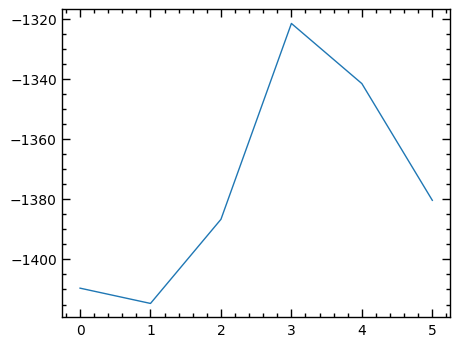

In [15]:
meandiffs = []
for i in range(len(Tconvs)-1):
    meandiffs.append(np.mean(Tconv[i+1]-Tconvs[i]))
plt.plot(meandiffs)

In [5]:
np.save("big_alms", fg_alm)

In [4]:
T_convs

NameError: name 'T_convs' is not defined

In [42]:
def calc_RMS_error(lmod=32, lmax=32):
    nside   = 32
    delta   = 1e-3
    Nlmax   = RS.get_size(lmax)
    Nlmod   = RS.get_size(lmod)
    npix    = hp.nside2npix(nside)
    lats = np.array([-26])#np.linspace(-80, 80, 100)#
    times = np.linspace(0, 24, 3, endpoint=False)
    nuarr   = np.linspace(50,100,51)
    narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
    
    # Generate foreground alm
    fg_alm     = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True)
    fg_alm_mod = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmod, nside=nside, use_mat_Y=True)
    
    # Generate observation matrix for the modelling and for the observations.
    mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=times, beam_use=narrow_cosbeam)
    mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))
    mat_A_mod = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmod, lats=lats, times=times, beam_use=narrow_cosbeam)
    mat_A_mod = BlockMatrix(mat=mat_A_mod, mode='block', nblock=len(nuarr))

    # Calculate RMS errors of the data vectors.
    dmax = mat_A@fg_alm
    dmod = mat_A_mod@fg_alm_mod
    return np.std(dmax.vector-dmod.vector)

def calc_d_vec(lmod=32, nside=64):
    npix    = hp.nside2npix(nside)
    lats = np.array([-26])
    times = np.linspace(0, 24, 3, endpoint=False)
    nuarr   = np.linspace(50,100,51)
    narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)
    
    # Generate foreground alm
    fg_alm_mod = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmod, nside=nside, use_mat_Y=True)
    
    # Generate observation matrix for the modelling and for the observations.
    mat_A_mod = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmod, lats=lats, times=times, beam_use=narrow_cosbeam)
    mat_A_mod = BlockMatrix(mat=mat_A_mod, mode='block', nblock=len(nuarr))

    # Calculate RMS errors of the data vectors.
    dmod = mat_A_mod@fg_alm_mod
    return dmod.vector

In [31]:
pars = [2, 4, 8, 16, 32, 64]
d_list = []
for par in pars:
    d_list.append(calc_d_vec(par))
    

calc_spherical_harmonic_matrix npix, nalm : 49152 6
calc_spherical_harmonic_matrix npix, nalm : 49152 15
calc_spherical_harmonic_matrix npix, nalm : 49152 45
calc_spherical_harmonic_matrix npix, nalm : 49152 153
successfully loaded spherical_harmonic_matrix npix, nalm : 49152 561
successfully loaded spherical_harmonic_matrix npix, nalm : 49152 2145


## TO RE-RUN WITHOUT RE-GENERATING RUN FROM HERE

Text(0.5, 0, '$l_\\mathrm{mod}$')

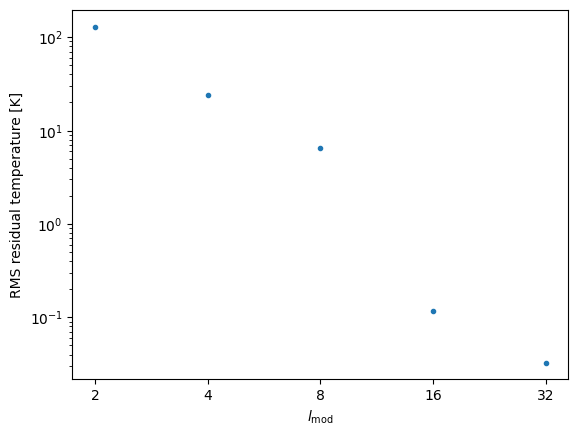

In [49]:
"""
This list is generated using NSIDE 64, with l=[2, 4, 8, 16, 32, 64].
"""
d_list = np.load('INLR_d_list.npy')

# Plot std error between each l value and the next l value, i.e. the first is RMS(l=2 - l=4).
xx = list(range(len(d_list)-1))
yy = [np.std(d_list[i]-d_list[i+1]) for i in range(len(d_list)-1)]
plt.loglog(pars[:-1],yy, '.')
plt.xticks(ticks=[], labels=[], minor=True)
plt.xticks(ticks=pars[:-1], labels=pars[:-1], minor=False)
plt.ylabel("RMS residual temperature [K]")
plt.xlabel(r"$l_\mathrm{mod}$")

In [52]:
print("RMS residuals between l=32 and l=64 are", yy[-1], "K")

RMS residuals between l=32 and l=64 are 0.03282776947832344 K


**So the argument is:** in the temperature observation space, the RMS of the residuals between each lmod and the lmod double that falls approximately as a power law. The RMS between l=32 and l=64 is approx 0.03 K, which is significantly smaller than the signal temperature. Therefore we can safely assume that l=32 is good enough for our efforts. Strictly speaking, a larger ell would be required in an actual modelling case, since the fractional error will likely be higher in brighter parts of the sky. But this is just details and we're doing a proof of concept.

In [35]:
np.save('INLR_d_list.npy', d_list)

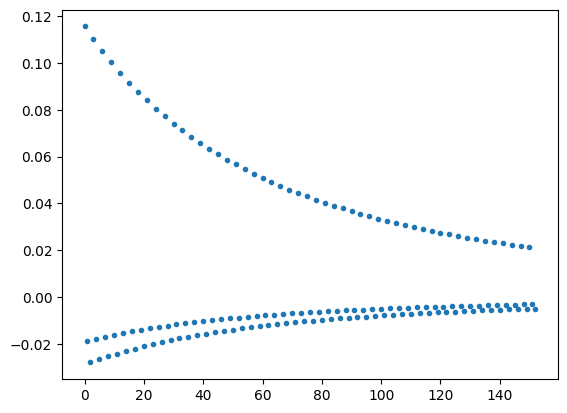

In [40]:
# Look at the residuals between the last two ell's - probably l=32 and l=64
plt.plot(d_list[-2]-d_list[-1], '.')

## Now investigate NSIDE

In [67]:
d_nsidelo = calc_d_vec(lmod=32, nside=64)
d_nsidehi = calc_d_vec(lmod=32, nside=128)

successfully loaded spherical_harmonic_matrix npix, nalm : 49152 561
calc_spherical_harmonic_matrix npix, nalm : 196608 561


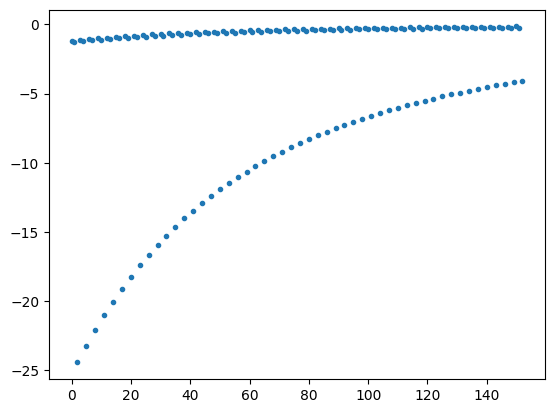

In [68]:
plt.plot(d_nsidelo-d_nsidehi, '.')

Fiddling with NSIDE changes things dramatically because it involves generating different degraded GSMAs. Therefore it's hard to directly compare different NSIDEs to each other. It'll be good enough to say that the NSIDE corresponds to pixel spacing of approx X, and l=32 corresponds to approx Y, and from there argue that my setup is alright.

So `np.sqrt(4*np.pi / (12*NSIDE**2))` is the approximate number of radians per pixel for a given NSIDE.

Meanwhile, the highest-resolution mode of a given ell splits the circumference of the sky into 2ell regions, with a peak in half of the regions, and a trough in the other half. We have `2*np.pi/(2*ELL)` radians per region.

To resolve this, we need at least one pixel per region. Therefore we need to have `np.sqrt(4*np.pi / (12*NSIDE**2)) <= 2*np.pi/(2*ELL)`

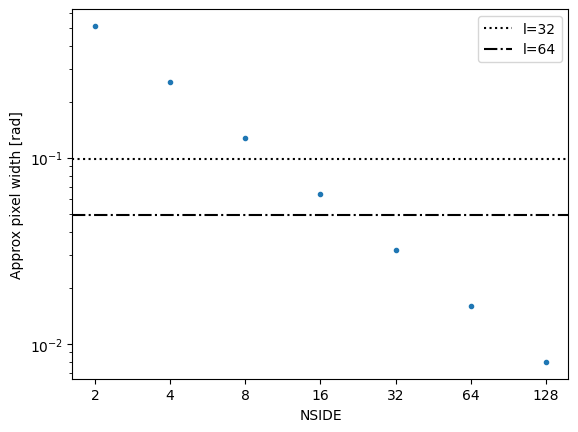

In [79]:
NSIDEs = [2, 4, 8, 16, 32, 64, 128]
ELLs   = [32, 64]
rads_NSIDE = [np.sqrt(4*np.pi / (12*NSIDE**2)) for NSIDE in NSIDEs]
rads_ELL = [2*np.pi/(2*ELL) for ELL in ELLs]
plt.loglog(NSIDEs, rads_NSIDE, '.')
sty = [':', '-.']
for ELL, rads, s in zip(ELLs, rads_ELL, sty):
    plt.axhline(y=rads, linestyle=s, label="l="+str(ELL), color='k')
plt.legend()
plt.xticks(ticks=[], labels=[], minor=True)
plt.xticks(ticks=NSIDEs, labels=NSIDEs, minor=False)
plt.xlabel("NSIDE")
plt.ylabel("Approx pixel width [rad]")
plt.show()

Can see that an NSIDE of 32 is definitely enough to capture the detail of ell=32, and even ell=64.

## Different Investigation: 
### To what extent does modelling nside=32 vs. nside=64 change the spectral complexity of the measured signal?

In [2]:
# Generate nside=32 and nside=64 skies.
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
lmax = 64
fg32 = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, use_mat_Y=True, nside=32)
fg64 = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, use_mat_Y=True, nside=64)
mat_A32 = FM.calc_observation_matrix_zenith_driftscan_multifreq(nuarr, nside=32, lmax=lmax, Ntau=1, lat=-26, lon=0, times=np.array([0]), beam_use=narrow_cosbeam)
mat_A64 = FM.calc_observation_matrix_zenith_driftscan_multifreq(nuarr, nside=64, lmax=lmax, Ntau=1, lat=-26, lon=0, times=np.array([0]), beam_use=narrow_cosbeam)



successfully loaded spherical_harmonic_matrix npix, nalm : 12288 2145
successfully loaded spherical_harmonic_matrix npix, nalm : 49152 2145
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 2145


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


successfully loaded spherical_harmonic_matrix npix, nalm : 49152 2145


In [12]:
temps32 = (mat_A32 @ fg32).vector
temps64 = (mat_A64 @ fg64).vector
np.save("temps32", temps32)
np.save("temps64", temps64)

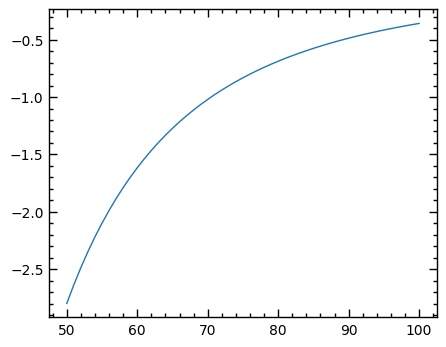

In [14]:
temps32 = np.load("temps32.npy")
temps64 = np.load("temps64.npy")
plt.plot(nuarr, temps32-temps64)


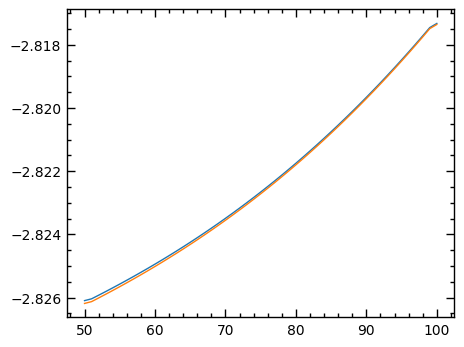

In [17]:
# Calculate the derivative d log T/d log nu for the two curves to better show spectral complexity.
temp_deriv32 = np.gradient(np.log(temps32), np.log(nuarr))
temp_deriv64 = np.gradient(np.log(temps64), np.log(nuarr))
plt.plot(nuarr, temp_deriv32)
plt.plot(nuarr, temp_deriv64)


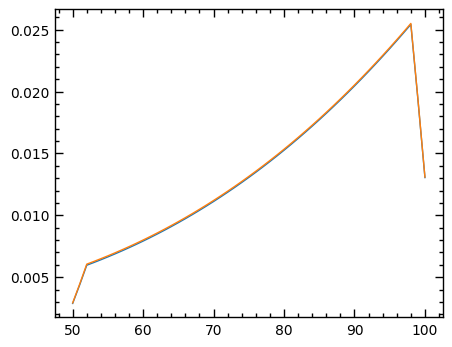

In [18]:
# Calculate the second derivatives to better show spectral complexity.
temp_second_deriv32 = np.gradient(temp_deriv32, np.log(nuarr))
temp_second_deriv64 = np.gradient(temp_deriv64, np.log(nuarr))
plt.plot(nuarr, temp_second_deriv32)
plt.plot(nuarr, temp_second_deriv64)
